In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

from training import Trainer
from load_data import LFWDataLoader

In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [3]:
dl = LFWDataLoader()

train_ds, train_dl = dl.train_dataset, dl.train_dataloader
val_ds, val_dl = dl.val_dataset, dl.val_dataloader
test_ds, test_dl = dl.test_dataset, dl.test_dataloader

(10586, 3, 125, 94)
(1323, 3, 125, 94)
(1324, 3, 125, 94)


In [34]:
from model import Encoder, Decoder, AutoEncoder
from loss import LogCoshLoss

model = AutoEncoder()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = Trainer(model, optim, device, train_dl, val_dl, lossfn=LogCoshLoss())
torch.cuda.empty_cache()
trainer.train_model(epochs=8)

54865110
EPOCH:  0
Iteration 0, loss = 0.1094
Avg Loss on Val: 0.09394984854791398

Iteration 500, loss = 0.0095
Avg Loss on Val: 0.012946206824223799

Iteration 1000, loss = 0.0083
Avg Loss on Val: 0.01093206190525141

EPOCH:  1
Iteration 0, loss = 0.0090
Avg Loss on Val: 0.01096031271425405

Iteration 500, loss = 0.0073
Avg Loss on Val: 0.009893511470995452

Iteration 1000, loss = 0.0064
Avg Loss on Val: 0.008119502461942514

EPOCH:  2
Iteration 0, loss = 0.0072
Avg Loss on Val: 0.008037813624045006

Iteration 500, loss = 0.0062
Avg Loss on Val: 0.008569936106975814

Iteration 1000, loss = 0.0061
Avg Loss on Val: 0.007892153316870668

EPOCH:  3
Iteration 0, loss = 0.0076
Avg Loss on Val: 0.007294086585367532

Iteration 500, loss = 0.0054
Avg Loss on Val: 0.007633130353196223

Iteration 1000, loss = 0.0055
Avg Loss on Val: 0.008312285394596875

EPOCH:  4
Iteration 0, loss = 0.0061
Avg Loss on Val: 0.007393483380626019

Iteration 500, loss = 0.0049
Avg Loss on Val: 0.007911049333730139

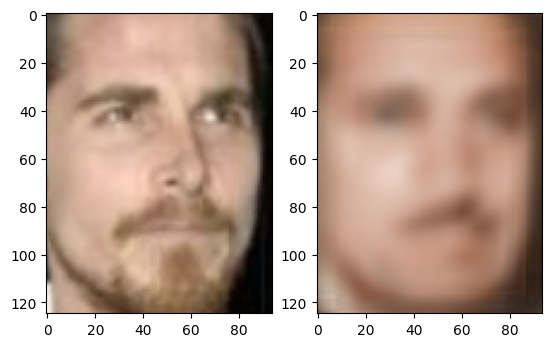

In [58]:
f = plt.figure()
tensor_image, = test_ds[200]
f.add_subplot(1,2,1)
plt.imshow(tensor_image.permute(1, 2, 0))
model.eval()
with torch.no_grad():
    tensor_image = tensor_image.unsqueeze(0)
    scores = model(tensor_image.to(device))

f.add_subplot(1,2,2)
scores = scores.squeeze(0)
plt.imshow(scores.to('cpu').permute(1, 2, 0))

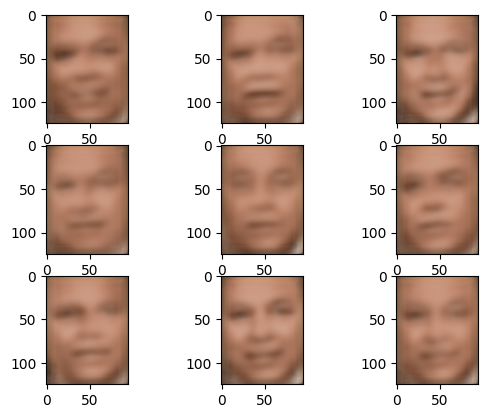

In [74]:
decoder = model.decoder
with torch.no_grad():
    randomData = torch.Tensor(np.random.normal(0.25,0.25,(9,64)))
    scores = model.decoder(randomData.to(device))
f = plt.figure()
for i in range(9):
    f.add_subplot(3,3,i+1)
    plt.imshow(scores[i].squeeze(0).to('cpu').permute(1, 2, 0))

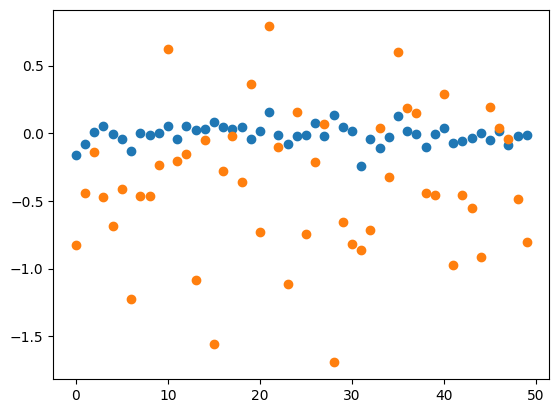

In [81]:
encoder = model.encoder
tensor_image, = test_ds[:50]
with torch.no_grad():
    latent_mu,latent_var = encoder(tensor_image.to(device))
latent_var = latent_var.to('cpu')
latent_mu = latent_mu.to('cpu')
f.add_subplot(1,2,1)
plt.scatter(range(50),latent_var[:,1])
f.add_subplot(1,2,2)
plt.scatter(range(50),latent_mu[:,1])

In [77]:
import gc 
# model = 1
# del model 
gc.collect()
plt.close()
with torch.no_grad():
    torch.cuda.empty_cache()